In [1]:
### Load libraries
import numpy as np
from functools import reduce
import scipy
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('white')
sns.set_style('ticks')
sns.set_context('notebook')
import h5py
import allel
import scipy.spatial
# set size of the labels to be more visible
plt.rcParams['axes.labelsize'] = 24
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20

In [3]:
# load data
mydata = h5py.File('ace1.h5', mode='r')
samples = pd.read_csv('samples.meta.txt', sep='\t')

In [4]:
### Select variants
variants = allel.VariantChunkedTable(mydata['variants'], names=['POS','REF', 'ALT', 'DP', 'MQ', 'QD'])
calldata = mydata['calldata']
genotypes = allel.GenotypeChunkedArray(calldata['GT'])

In [5]:
# filter the variants to have a depht quality superior to 5
#http://alimanfoo.github.io/2015/09/28/fast-pca.html
filter_expression = '(QD > 5)'
variant_selection = variants.eval(filter_expression)[:]

In [6]:
#select the population name to be used
sample_selection = samples.population.isin({'CMgam', 'UGgam', 'BFgam', 'GW', 'AOcol', 'BFcol', 'CIcol', 'GAgam', 'GM', 'GHcol', 'KE', 'GNgam', 'FRgam', 'GHgam', 'GQgam', 'GNcol'}).values
# grab the individual and only the varians that passed the filtration step
geno = genotypes.subset(variant_selection, sample_selection)

sample_subset = samples[sample_selection]

subpops = {
    'all': list(range(len(sample_subset))),
    'AOcol': sample_subset[sample_subset.population == 'AOcol'].index.tolist(),
    'BFcol': sample_subset[sample_subset.population == 'BFcol'].index.tolist(),
    'CIcol': sample_subset[sample_subset.population == 'CIcol'].index.tolist(),  
    'GAgam': sample_subset[sample_subset.population == 'GAgam'].index.tolist(),  
    'GHcol': sample_subset[sample_subset.population == 'GHcol'].index.tolist(),   
    'GNcol': sample_subset[sample_subset.population == 'GNcol'].index.tolist(),    
    'BFgam': sample_subset[sample_subset.population == 'BFgam'].index.tolist(),
    'CMgam': sample_subset[sample_subset.population == 'CMgam'].index.tolist(),
    'FRgam': sample_subset[sample_subset.population == 'FRgam'].index.tolist(),
    'GHgam': sample_subset[sample_subset.population == 'GHgam'].index.tolist(),
    'GNgam': sample_subset[sample_subset.population == 'GNgam'].index.tolist(),
    'GQgam': sample_subset[sample_subset.population == 'GQgam'].index.tolist(),        
    'UGgam': sample_subset[sample_subset.population == 'UGgam'].index.tolist(),
    'GM': sample_subset[sample_subset.population == 'GM'].index.tolist(),    
    'GW': sample_subset[sample_subset.population == 'GW'].index.tolist(),
    'KE': sample_subset[sample_subset.population == 'KE'].index.tolist(),
}  

pca_subpops = geno.count_alleles_subpops(subpops, max_allele=3)

pca = pca_subpops['all'][:]

In [7]:
# select the segregating variants and the genotype to be used for the pca
pca_selection = (pca.max_allele() == 1) & (pca[:, :2].min(axis=1) > 5)
indices = np.nonzero(pca_selection)[0]
indices_ds = np.random.choice(indices, size=1267, replace=False)
indices_ds.sort()

In [8]:
len(indices_ds)

1267

In [9]:
#create a matrix with all the 1267 columns
genotypes_pca = geno.take(indices_ds, axis=0)

In [10]:
#reduice the dimensions and consider only the principal components
gn = genotypes_pca.to_n_alt()[:]

In [11]:
#establish the point coordinates for the pca value selected 
coords, model = allel.pca(gn)

In [19]:
#define the colors sufficient for the 16 population
c = sns.set_palette(sns.color_palette(palette=['lightcoral', 'blue', 'springgreen', 'orange', 'moccasin', 'lime', 'purple', 'red', 'silver', 'saddlebrown', 'crimson', 'midnightblue', 'aquamarine', 'steelblue', 'gold', 'dimgray'], n_colors=16, desat=None))

In [20]:
### Plotting
# function to plot pcs againt each other
# http://alimanfoo.github.io/2015/09/28/fast-pca.html
def plot_pca_coords(coords, model, pc1, pc2, ax):
    x = coords[:, pc1]
    y = coords[:, pc2]
    
    for pop in ['AOcol', 'BFcol', 'CIcol', 'GHcol', 'GNcol', 'BFgam', 'CMgam', 'FRgam', 'GAgam', 'GHgam', 'GNgam', 'GQgam', 'UGgam', 'GM', 'GW', 'KE']:
        
        flt = (sample_subset.population == pop).values
        ax.plot(x[flt], y[flt], marker='o', linestyle=' ', label=pop, markersize=6)
    ax.set_xlabel('PC%s (%.1f%%)' % (pc1+1, model.explained_variance_ratio_[pc1]*100))
    ax.set_ylabel('PC%s (%.1f%%)' % (pc2+1, model.explained_variance_ratio_[pc2]*100))

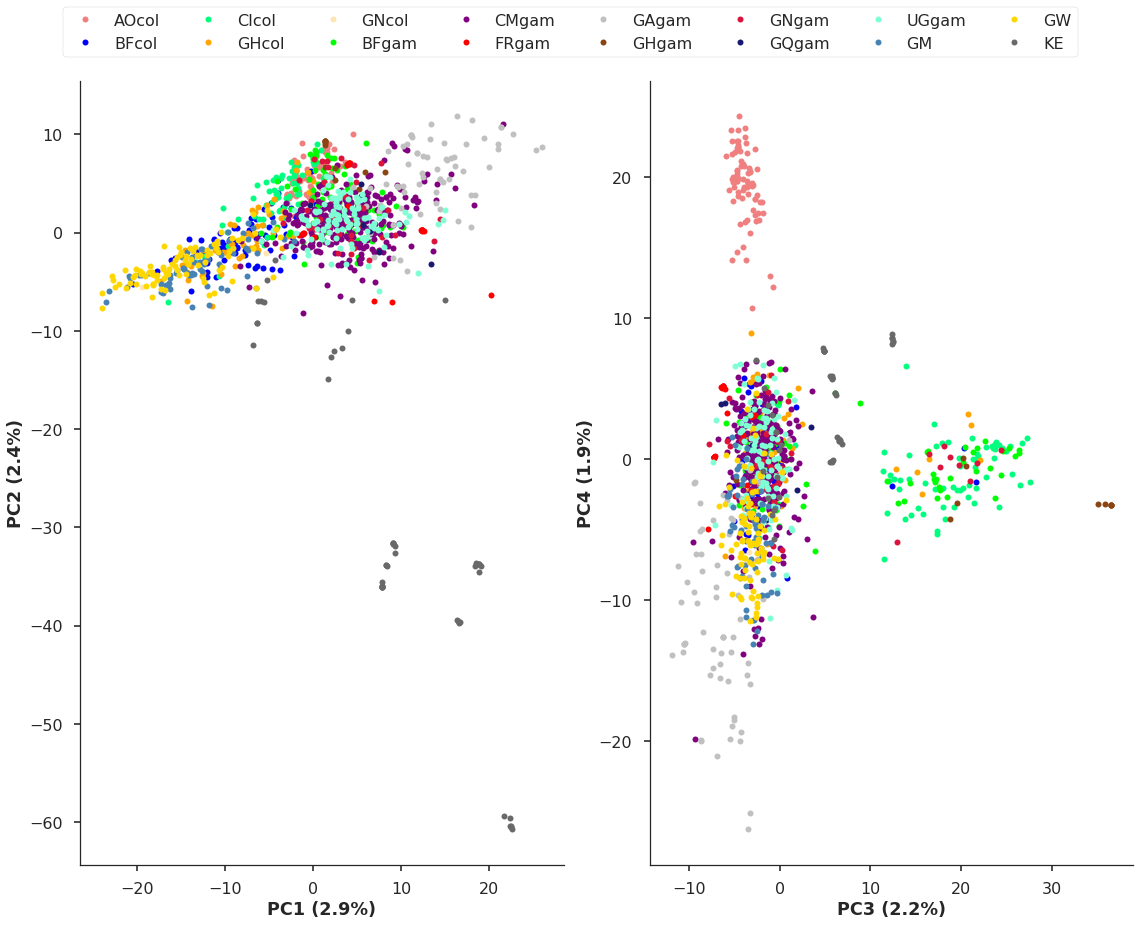

In [21]:
# plots figures using seaborn-poster style
plt.style.use(['seaborn-poster'])

plt.rcParams['axes.grid'] = False
fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, figsize=(16, 12))

sns.despine(ax=ax1)
plot_pca_coords(coords, model, 0, 1, ax1)

sns.despine(ax=ax2)
plot_pca_coords(coords, model, 2, 3, ax2)

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(0.5, 1.08), loc='upper center', ncol=8, )
fig.tight_layout()
plt.show()